In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping

import wandb
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import pandas as pd

from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder, GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, RMSE, QuantileLoss, PoissonLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 128 if AVAIL_GPUS else 32

In [2]:
pl.seed_everything(125)

Global seed set to 125


125

In [3]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## 1. Data Description

$$
m\ddot{u} + c\dot{u} + ku = 0
$$

* $m$ = 1kg
* $k$ = 200N/m
* $c$ = $\zeta \cdot 2 \sqrt{k\cdot m}$

In [4]:
m = 1
k = 200
c_s = 2 * np.sqrt(k * m)

In [5]:
ncfile = nc.Dataset("../data/sho_newmark_beta.nc")
var = ncfile.variables

df = pd.DataFrame({
    't': np.tile(var['t'][:], 3),
    'x': np.concatenate([var['x_0'][:], var['x_1'][:], var['x_2'][:]]),
    'v': np.concatenate([var['v_0'][:], var['v_1'][:], var['v_2'][:]]),
    'a': np.concatenate([var['a_0'][:], var['a_1'][:], var['a_2'][:]]),
    'zeta': np.repeat([var['zeta_0'][:][0], var['zeta_1'][:][0], var['zeta_2'][:][0]], len(var['t'][:])),
    'group': np.repeat([0,1,2], len(var['t'][:]))
})

E = 0.5 * m * df['v']**2 + 0.5 * 200 * df['x']**2
df.insert(4, 'E', E)

time_idx = np.tile(np.arange(len(var['t'][:])), 3)
df['time_idx'] = time_idx
df

,t,x,v,a,E,zeta,group,time_idx
0,0.000,0.100000,0.000000,-20.000000,1.000000,0.00,0,0
1,0.001,0.099990,-0.019999,-19.998000,1.000000,0.00,0,1
2,0.002,0.099960,-0.039994,-19.992001,1.000000,0.00,0,2
3,0.003,0.099910,-0.059981,-19.982003,1.000000,0.00,0,3
4,0.004,0.099840,-0.079956,-19.968010,1.000000,0.00,0,4
...,...,...,...,...,...,...,...,...
29998,9.996,-0.005909,-0.003139,1.183676,0.003497,0.02,2,9996
29999,9.997,-0.005912,-0.001956,1.183516,0.003497,0.02,2,9997
30000,9.998,-0.005913,-0.000772,1.183119,0.003497,0.02,2,9998
30001,9.999,-0.005914,0.000411,1.182486,0.003497,0.02,2,9999


In [6]:
df.describe()

,t,x,v,a,E,zeta,group,time_idx
count,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000,30003.000000,30003.00000,30003.00000
mean,5.000000,0.000005,-0.014334,0.002178,0.503032,0.010000,1.00000,5000.00000
std,2.887088,0.050165,0.708936,10.031599,0.410637,0.008165,0.81651,2887.08812
min,0.000000,-0.100000,-1.414214,-20.000000,0.003497,0.000000,0.00000,0.00000
25%,2.500000,-0.031463,-0.460426,-6.307524,0.093861,0.000000,0.00000,2500.00000
50%,5.000000,-0.000006,-0.015883,0.004272,0.389655,0.010000,1.00000,5000.00000
75%,7.500000,0.031593,0.430537,6.288676,1.000000,0.020000,2.00000,7500.00000
max,10.000000,0.100000,1.414214,20.000000,1.000000,0.020000,2.00000,10000.00000


In [7]:
df.zeta.unique()

array([0.  , 0.01, 0.02])

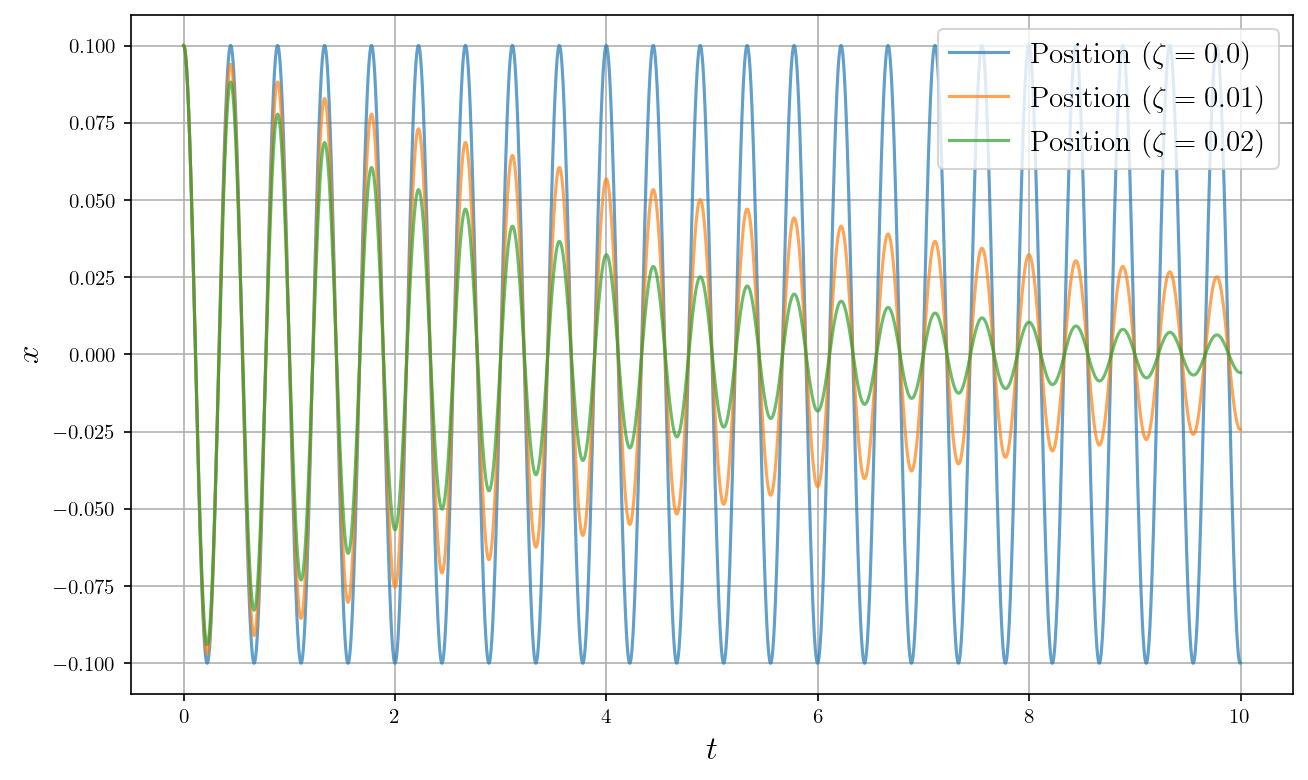

In [8]:
plt.figure(figsize=(10, 6), dpi=150)
for zeta in df.zeta.unique():
    dg = df[df['zeta'] == zeta]
    plt.plot(dg['t'], dg['x'], label=rf'Position ($\zeta={zeta}$)', alpha=0.7)
plt.legend(fontsize=14)
plt.grid()
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$x$", fontsize=16)
plt.show()

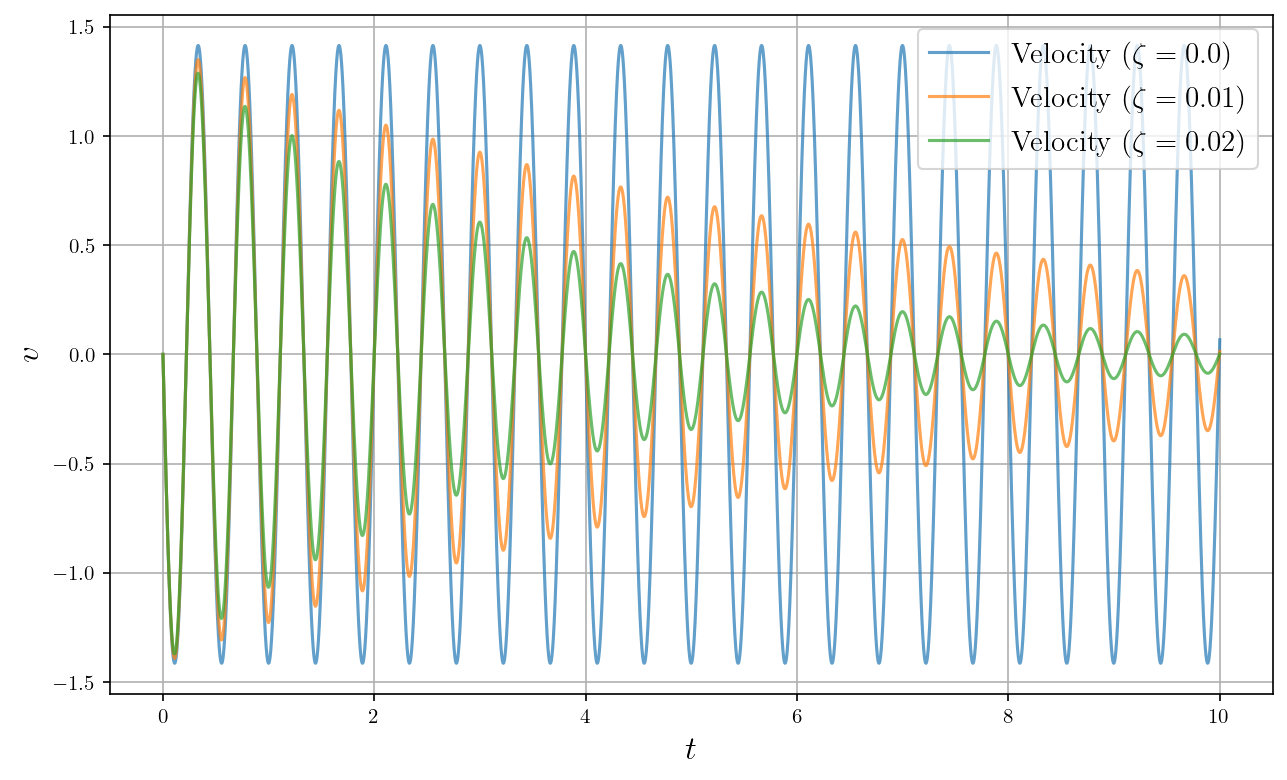

In [9]:
plt.figure(figsize=(10, 6), dpi=150)
for zeta in df.zeta.unique():
    dg = df[df['zeta'] == zeta]
    plt.plot(dg['t'], dg['v'], label=rf'Velocity ($\zeta={zeta}$)', alpha=0.7)
plt.legend(fontsize=14)
plt.grid()
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$v$", fontsize=16)
plt.show()

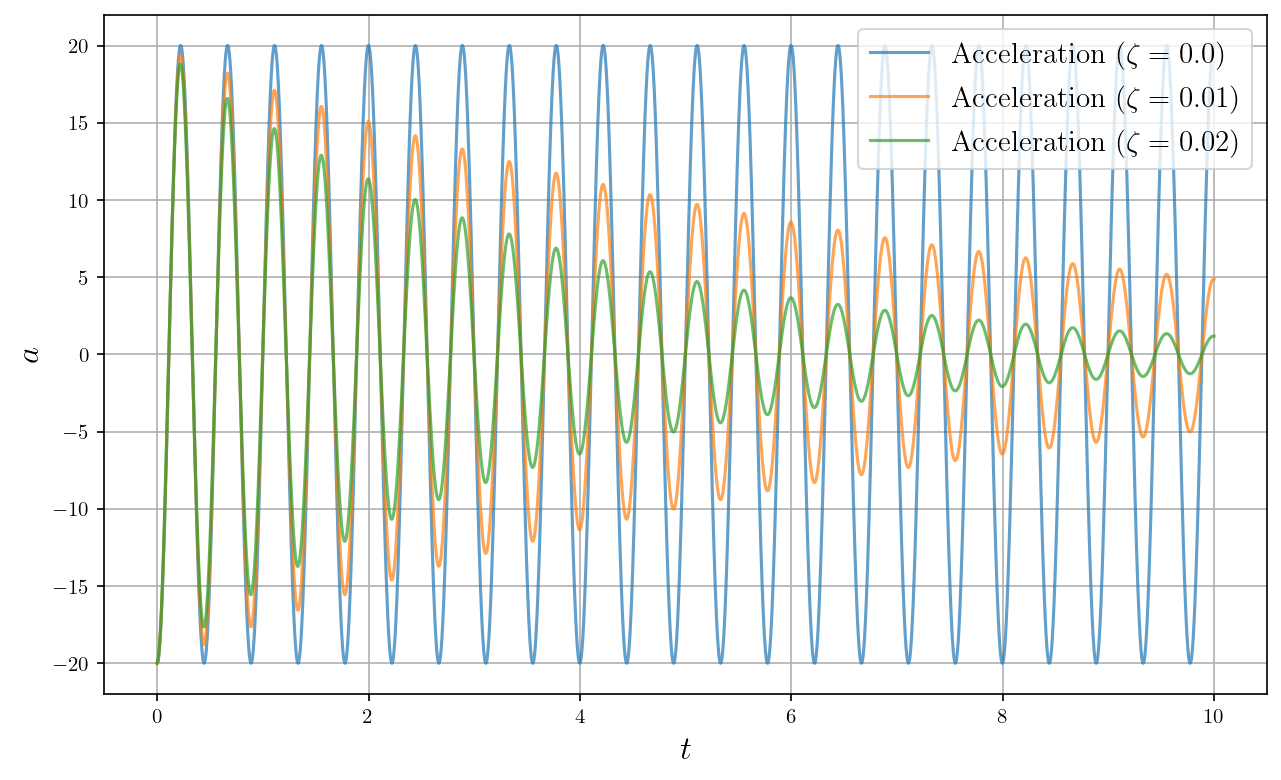

In [10]:
plt.figure(figsize=(10, 6), dpi=150)
for zeta in df.zeta.unique():
    dg = df[df['zeta'] == zeta]
    plt.plot(dg['t'], dg['a'], label=rf'Acceleration ($\zeta={zeta}$)', alpha=0.7)
plt.legend(fontsize=14)
plt.grid()
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$a$", fontsize=16)
plt.show()

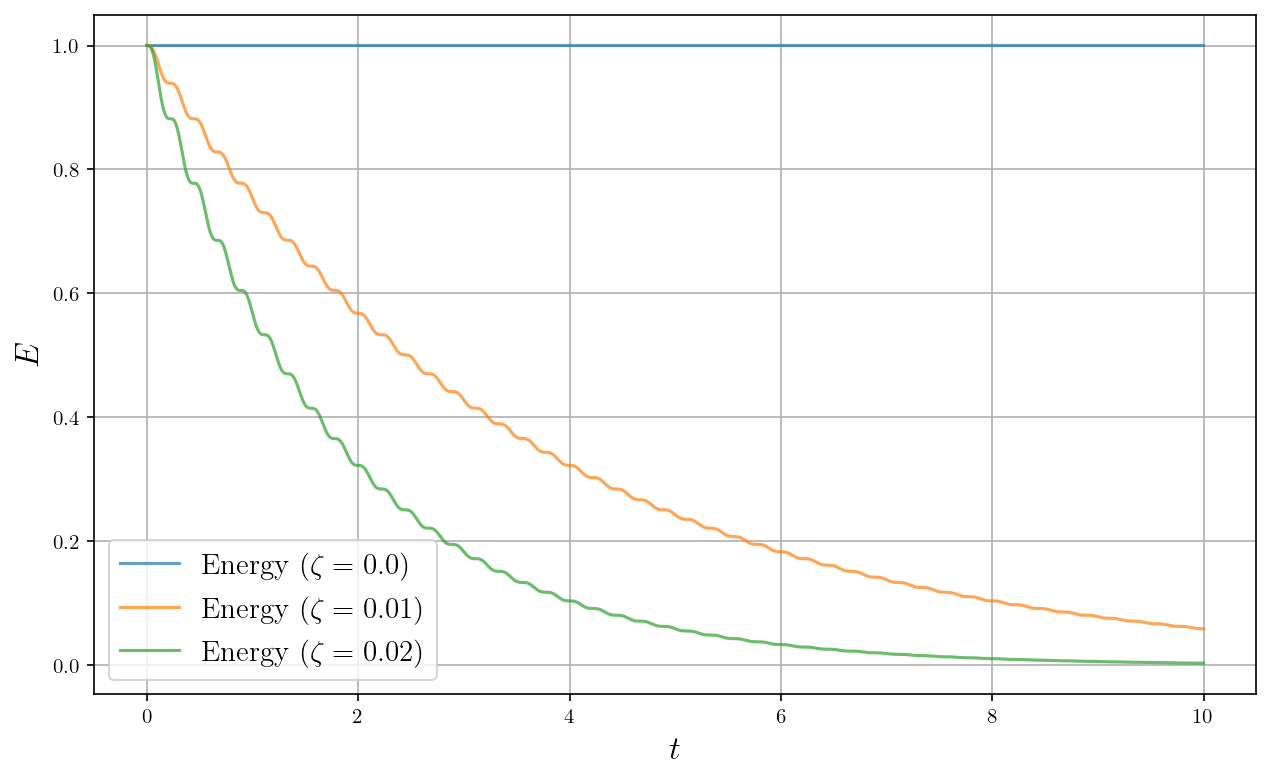

In [11]:
plt.figure(figsize=(10, 6), dpi=150)
for zeta in df.zeta.unique():
    dg = df[df['zeta'] == zeta]
    plt.plot(dg['t'], dg['E'], label=rf'Energy ($\zeta={zeta}$)', alpha=0.7)
plt.legend(fontsize=14)
plt.grid()
plt.xlabel(r"$t$", fontsize=16)
plt.ylabel(r"$E$", fontsize=16)
plt.show()

## 2. TimeSeries Data

In [12]:
ts_data = df.astype(dict(group=str))
ts_data

,t,x,v,a,E,zeta,group,time_idx
0,0.000,0.100000,0.000000,-20.000000,1.000000,0.00,0,0
1,0.001,0.099990,-0.019999,-19.998000,1.000000,0.00,0,1
2,0.002,0.099960,-0.039994,-19.992001,1.000000,0.00,0,2
3,0.003,0.099910,-0.059981,-19.982003,1.000000,0.00,0,3
4,0.004,0.099840,-0.079956,-19.968010,1.000000,0.00,0,4
...,...,...,...,...,...,...,...,...
29998,9.996,-0.005909,-0.003139,1.183676,0.003497,0.02,2,9996
29999,9.997,-0.005912,-0.001956,1.183516,0.003497,0.02,2,9997
30000,9.998,-0.005913,-0.000772,1.183119,0.003497,0.02,2,9998
30001,9.999,-0.005914,0.000411,1.182486,0.003497,0.02,2,9999


In [13]:
max_encoder_length = 100
max_prediction_length = 20

cutoff = ts_data["time_idx"].max() - max_prediction_length

ds_train = TimeSeriesDataSet(
    ts_data[lambda x: x.time_idx <= cutoff],
    target="x",
    time_idx="time_idx",
    group_ids=["group"],
    static_reals=["zeta"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["x", "v", "a", "E"],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
#     target_normalizer=GroupNormalizer(
#         groups=["group"], transformation="softplus"
#     )
)

ds_val = TimeSeriesDataSet.from_dataset(ds_train, ts_data, predict=True, stop_randomization=True)


In [14]:
ds_val.get_parameters()

{'time_idx': 'time_idx',
 'target': 'x',
 'group_ids': ['group'],
 'weight': None,
 'max_encoder_length': 100,
 'min_encoder_length': 50,
 'min_prediction_idx': 0,
 'min_prediction_length': 20,
 'max_prediction_length': 20,
 'static_categoricals': [],
 'static_reals': ['zeta', 'encoder_length'],
 'time_varying_known_categoricals': [],
 'time_varying_known_reals': ['time_idx'],
 'time_varying_unknown_categoricals': [],
 'time_varying_unknown_reals': ['x', 'v', 'a', 'E'],
 'variable_groups': {},
 'constant_fill_strategy': {},
 'allow_missing_timesteps': False,
 'lags': {},
 'add_relative_time_idx': False,
 'add_target_scales': False,
 'add_encoder_length': True,
 'target_normalizer': EncoderNormalizer(method='standard', center=True, max_length=None, transformation=None),
 'categorical_encoders': {'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
 'scalers': {'zeta': StandardScaler(),
  'encoder_length': StandardScaler(),
  'time_idx': StandardScaler(),
  'v': StandardScale

In [15]:
dl_train = ds_train.to_dataloader(
    train=True, batch_size=32, num_workers=0, batch_sampler="synchronized"
)

dl_val = ds_val.to_dataloader(
    train=False, batch_size=32, num_workers=0, batch_sampler="synchronized"
)

In [16]:
# calc basline abs error
actuals = torch.cat([y[0] for x, y in iter(dl_val)])
baseline_pred = Baseline().predict(dl_val)
SMAPE()(baseline_pred, actuals)

tensor(0.0227)

## 3. Temporal Fusion Transformer

In [17]:
pl.seed_everything(125)

model2 = TemporalFusionTransformer.from_dataset(
    ds_train,
    learning_rate=0.01,
    hidden_size=32,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=16,
    output_size=7, # 7-quantiles
    loss=QuantileLoss(),
    reduce_on_plateau_patience=4,
)

print(f"Number of parameters in network: {model2.size()/1e3:.1f}k")

Global seed set to 125


Number of parameters in network: 68.4k


In [18]:
wandb_logger = WandbLogger(
    project='TFT_Mech'
)

trainer = Trainer(
    logger=wandb_logger,
    gpus=AVAIL_GPUS,
    gradient_clip_val=1e-1,
    enable_progress_bar=False,
)

wandb: Currently logged in as: axect (use `wandb login --relogin` to force relogin)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [19]:
model2.predict(ds_val).shape

torch.Size([3, 20])

In [20]:
# # find optimal learning rate
# res = trainer.tuner.lr_find(
#     model2,
#     train_dataloaders=dl_train,
#     val_dataloaders=dl_val,
#     max_lr=10.0,
#     min_lr=1e-6,
# )

# print(f"suggested learning rate: {res.suggestion()}")
# fig = res.plot(show=True, suggest=True)
# fig.show()

In [21]:
# model2 = TemporalFusionTransformer.from_dataset(
#     ds_train,
#     learning_rate=res.suggestion(),
#     hidden_size=20,
#     attention_head_size=1,
#     dropout=0.1,
#     hidden_continuous_size=10,
#     output_size=7, # 7-quantiles
#     loss=QuantileLoss(),
# #     reduce_on_plateau_patience=4,
# )

In [22]:
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=10,
    verbose=False,
    mode="min"
)

trainer = Trainer(
    logger=wandb_logger,
    max_epochs=5,
    gpus=AVAIL_GPUS,
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    enable_progress_bar=False,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [23]:
trainer.fit(model2, train_dataloaders=dl_train, val_dataloaders=dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 224   
4  | static_variable_selection          | VariableSelectionNetwork        | 3.7 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 9.8 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm 

In [24]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
train_loss_epoch,█▂▂▁▁
train_loss_step,█▃▂▂▁▂▁▂▁▄▁▁▁▂▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▂▁▂▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_MAE,█▂▆▁▂
val_MAPE,█▂▃▁▂
val_RMSE,█▂█▁▂
val_SMAPE,█▂▃▁▂
val_loss,█▂▅▁▂
epoch,5
train_loss_epoch,0.00051


In [25]:
best_path2 = trainer.checkpoint_callback.best_model_path
print(best_path2)
best_model2 = TemporalFusionTransformer.load_from_checkpoint(best_path2)
best_model2.eval()

/home/xteca/Documents/Project/Machine_Learning/TFT_Mech/notes/TFT_Mech/dw5q4o24/checkpoints/epoch=4-step=49575.ckpt


TemporalFusionTransformer(
  	"attention_head_size":               4
  	"categorical_groups":                {}
  	"causal_attention":                  True
  	"dropout":                           0.1
  	"embedding_labels":                  {}
  	"embedding_paddings":                []
  	"embedding_sizes":                   {}
  	"hidden_continuous_size":            16
  	"hidden_continuous_sizes":           {}
  	"hidden_size":                       32
  	"learning_rate":                     0.01
  	"log_gradient_flow":                 False
  	"log_interval":                      -1
  	"log_val_interval":                  -1
  	"logging_metrics":                   ModuleList(
  	  (0): SMAPE()
  	  (1): MAE()
  	  (2): RMSE()
  	  (3): MAPE()
  	)
  	"loss":                              QuantileLoss(quantiles=[0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98])
  	"lstm_layers":                       1
  	"max_encoder_length":                100
  	"monotone_constaints":               {}
  	"op

In [26]:
# calc baseline abs error
actuals = torch.cat([y[0] for x, y in iter(dl_val)])
predictions = best_model2.predict(dl_val)
(actuals - predictions).abs().mean()

tensor(0.0003)

In [27]:
raw_preds, x = best_model2.predict(dl_val, mode="raw", return_x=True)

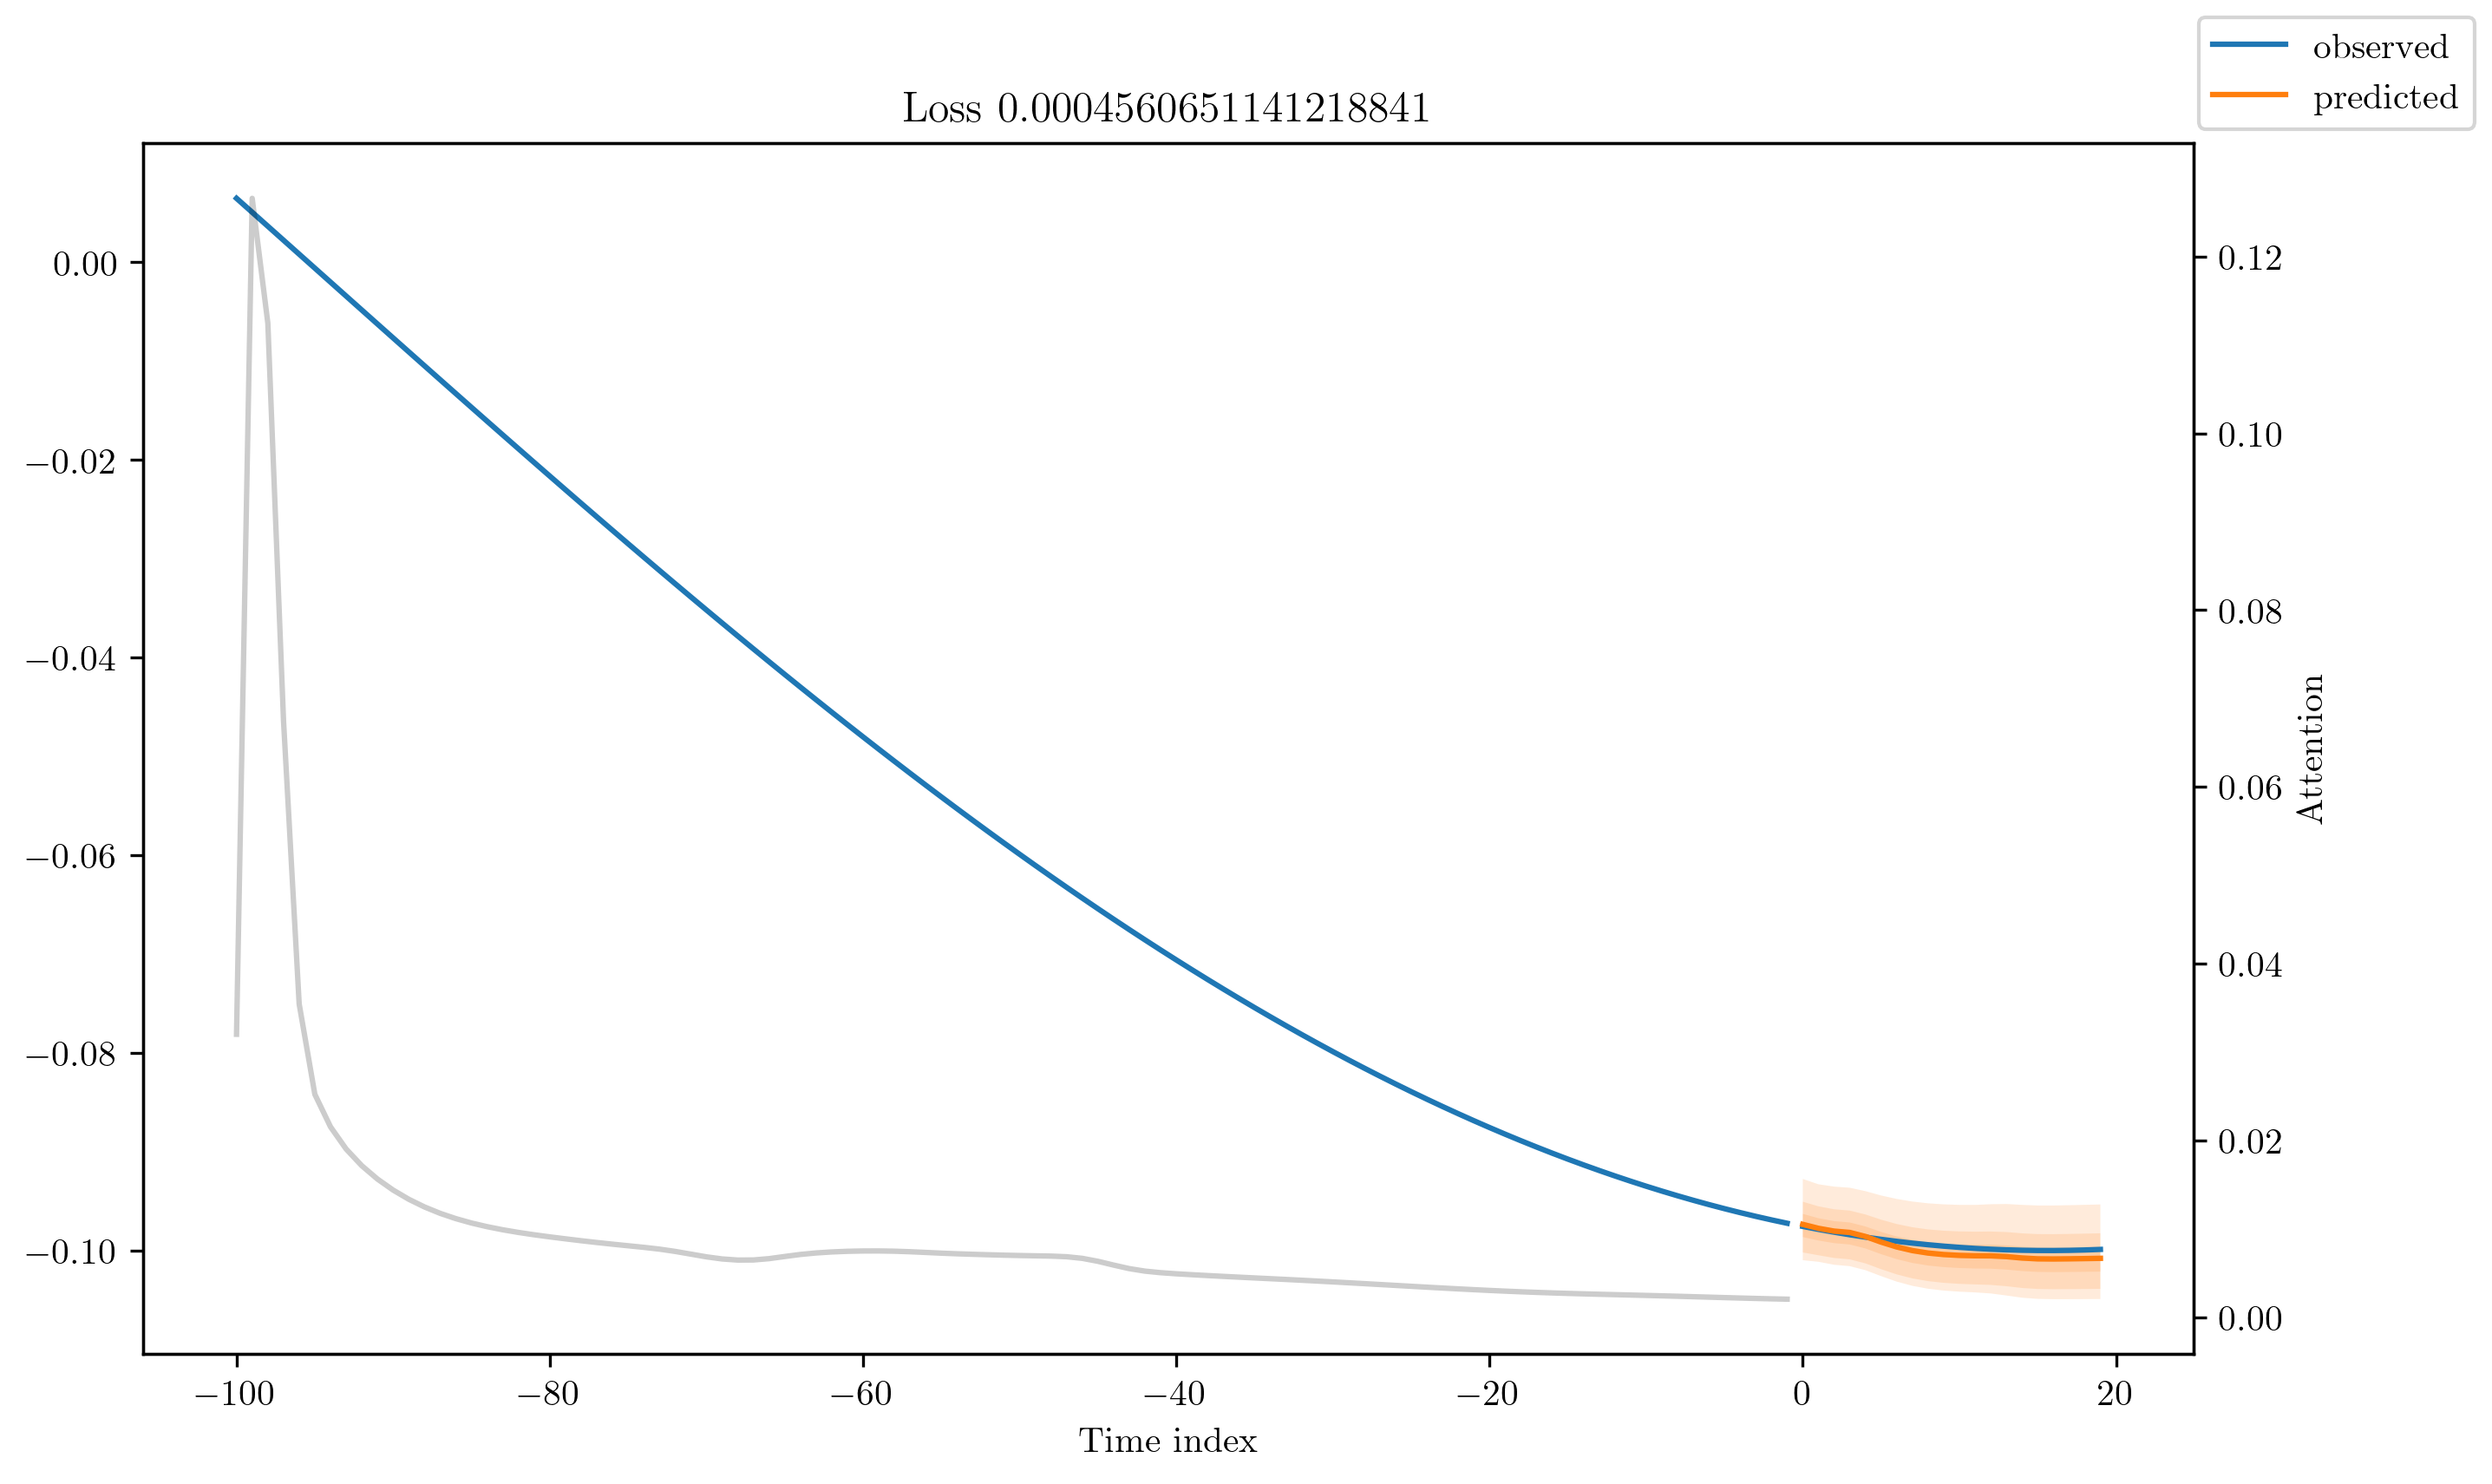

In [28]:
fig = best_model2.plot_prediction(x, raw_preds, idx=0, add_loss_to_title=True)
fig.set_dpi(300)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.savefig("tft_loss.png")
fig.show()

The grey lines denote the amount of attention the model pays to different points in time when making the prediction

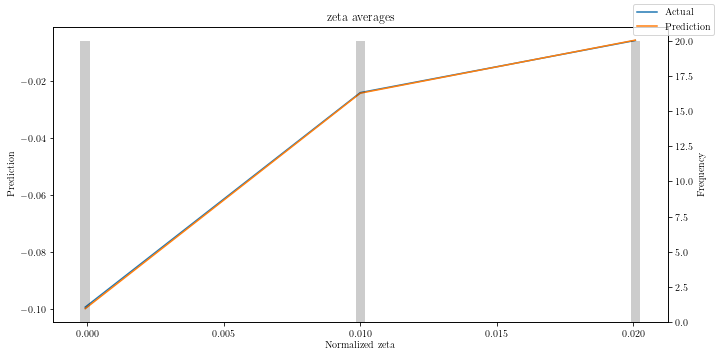

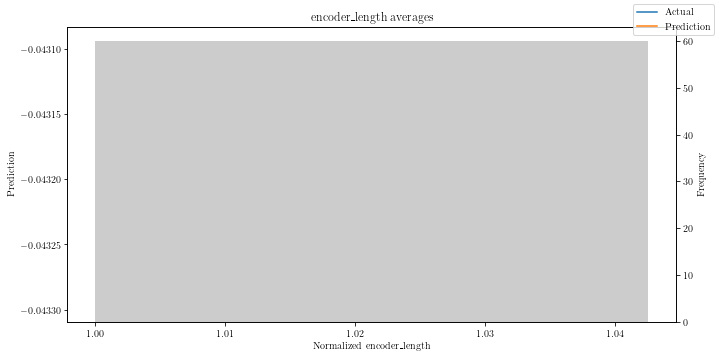

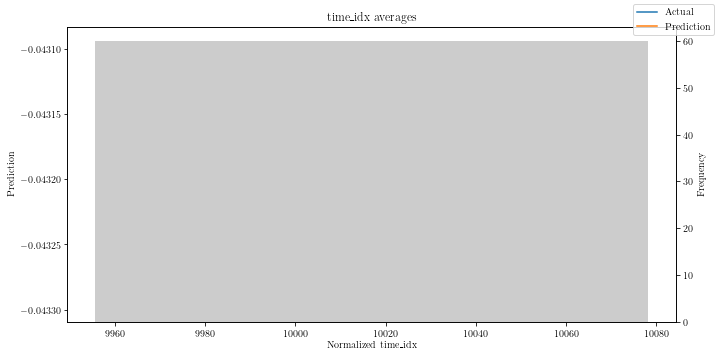

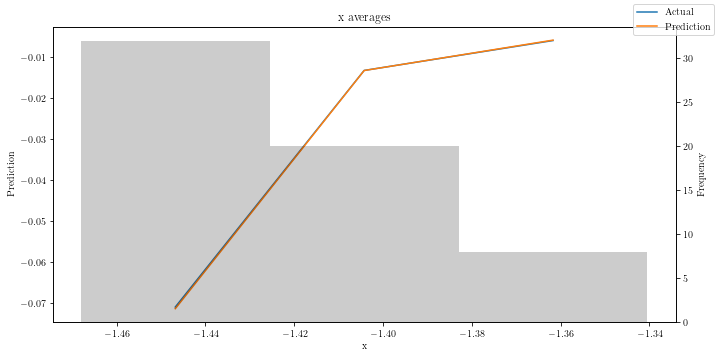

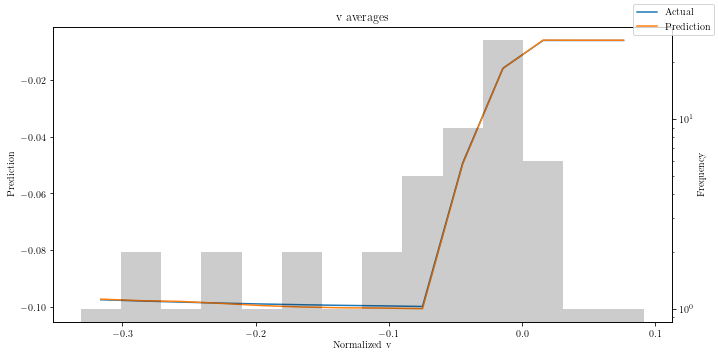

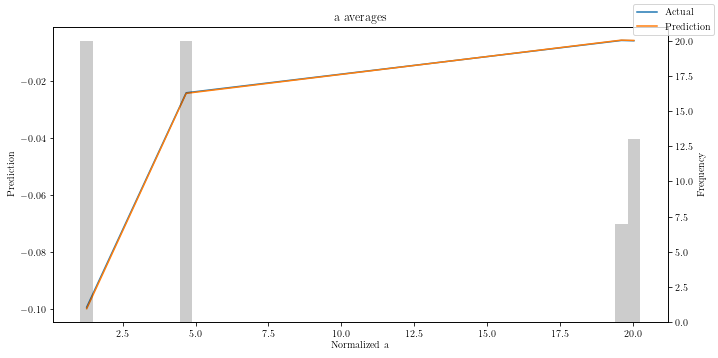

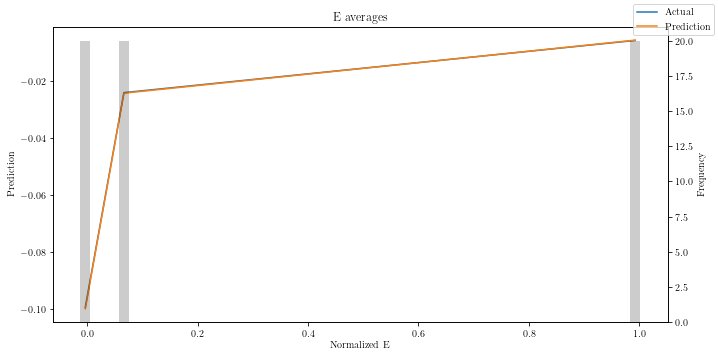

In [29]:
predictions, x_p = best_model2.predict(dl_val, return_x=True)
predictions_vs_actuals = best_model2.calculate_prediction_actual_by_variable(x_p, predictions)
best_model2.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [30]:
x_val, y_val = ds_val[0]

In [51]:
ds_val[1]

({'x_cat': tensor([], size=(120, 0), dtype=torch.int64),
  'x_cont': tensor([[ 0.0000e+00,  1.0000e+00,  1.6975e+00,  1.9238e+00, -4.7144e-01,
           -2.8927e-02, -1.0770e+00],
          [ 0.0000e+00,  1.0000e+00,  1.6979e+00,  1.8793e+00, -4.7182e-01,
           -2.1960e-02, -1.0771e+00],
          [ 0.0000e+00,  1.0000e+00,  1.6982e+00,  1.8347e+00, -4.7210e-01,
           -1.4990e-02, -1.0772e+00],
          [ 0.0000e+00,  1.0000e+00,  1.6986e+00,  1.7900e+00, -4.7229e-01,
           -8.0192e-03, -1.0773e+00],
          [ 0.0000e+00,  1.0000e+00,  1.6989e+00,  1.7454e+00, -4.7237e-01,
           -1.0481e-03, -1.0774e+00],
          [ 0.0000e+00,  1.0000e+00,  1.6993e+00,  1.7008e+00, -4.7236e-01,
            5.9215e-03, -1.0774e+00],
          [ 0.0000e+00,  1.0000e+00,  1.6996e+00,  1.6562e+00, -4.7225e-01,
            1.2888e-02, -1.0775e+00],
          [ 0.0000e+00,  1.0000e+00,  1.6999e+00,  1.6115e+00, -4.7204e-01,
            1.9851e-02, -1.0776e+00],
          [ 0.0000e+0

In [31]:
x_val['encoder_target']

tensor([ 0.0065,  0.0051,  0.0036,  0.0022,  0.0008, -0.0006, -0.0020, -0.0034,
        -0.0048, -0.0062, -0.0077, -0.0091, -0.0105, -0.0119, -0.0133, -0.0147,
        -0.0161, -0.0175, -0.0189, -0.0203, -0.0216, -0.0230, -0.0244, -0.0258,
        -0.0271, -0.0285, -0.0298, -0.0312, -0.0325, -0.0339, -0.0352, -0.0365,
        -0.0378, -0.0391, -0.0404, -0.0417, -0.0430, -0.0443, -0.0455, -0.0468,
        -0.0480, -0.0493, -0.0505, -0.0517, -0.0529, -0.0541, -0.0553, -0.0565,
        -0.0576, -0.0588, -0.0599, -0.0610, -0.0621, -0.0632, -0.0643, -0.0654,
        -0.0665, -0.0675, -0.0686, -0.0696, -0.0706, -0.0716, -0.0726, -0.0735,
        -0.0745, -0.0754, -0.0763, -0.0772, -0.0781, -0.0790, -0.0799, -0.0807,
        -0.0815, -0.0824, -0.0831, -0.0839, -0.0847, -0.0854, -0.0862, -0.0869,
        -0.0876, -0.0882, -0.0889, -0.0895, -0.0901, -0.0908, -0.0913, -0.0919,
        -0.0925, -0.0930, -0.0935, -0.0940, -0.0945, -0.0949, -0.0953, -0.0958,
        -0.0962, -0.0965, -0.0969, -0.09

In [32]:
y_val[0]

tensor([-0.0976, -0.0979, -0.0981, -0.0984, -0.0986, -0.0989, -0.0991, -0.0993,
        -0.0994, -0.0996, -0.0997, -0.0998, -0.0999, -0.0999, -0.1000, -0.1000,
        -0.1000, -0.1000, -0.0999, -0.0999])

In [33]:
new_x_val = torch.concat([x_val['encoder_target'][20:], y_val[0]])

In [34]:
new_x_val.shape

torch.Size([100])

In [35]:
ds_val

TimeSeriesDataSet[length=3](
	time_idx='time_idx',
	target='x',
	group_ids=['group'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=50,
	min_prediction_idx=0,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=['zeta', 'encoder_length'],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['x', 'v', 'a', 'E'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=True,
	target_normalizer=EncoderNormalizer(method='standard', center=True, max_length=None, transformation=None),
	categorical_encoders={'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'zeta': StandardScaler(), 'encoder_length': StandardScaler(), 'time_idx': StandardScaler(), 'v': StandardScaler(), 'a': StandardScaler(), 'E': StandardScaler()},


In [36]:
x_val, y_val = ds_val[0]

In [39]:
ts_test = pd.DataFrame(
    dict(
        y=torch.concat([x_val['encoder_target'][20:], y_val[0], torch.repeat_interleave(torch.tensor(0), 20)]),
        group=np.repeat(0, 120),
        time_idx=np.arange(900,1020)
    )
)
ts_test = ts_test.astype(dict(group=str))
ts_test

,y,group,time_idx
0,-0.021635,0,900
1,-0.023014,0,901
2,-0.024388,0,902
3,-0.025757,0,903
4,-0.027121,0,904
...,...,...,...
115,0.000000,0,1015
116,0.000000,0,1016
117,0.000000,0,1017
118,0.000000,0,1018


In [49]:
max_encoder_length = 100
max_prediction_length = 20

ds_test = TimeSeriesDataSet(
    ts_test,
    target="y",
    time_idx="time_idx",
    group_ids=["group"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_reals=["y"],
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length
)

In [50]:
ds_test

TimeSeriesDataSet[length=1](
	time_idx='time_idx',
	target='y',
	group_ids=['group'],
	weight=None,
	max_encoder_length=100,
	min_encoder_length=100,
	min_prediction_idx=900,
	min_prediction_length=20,
	max_prediction_length=20,
	static_categoricals=[],
	static_reals=[],
	time_varying_known_categoricals=[],
	time_varying_known_reals=['time_idx'],
	time_varying_unknown_categoricals=[],
	time_varying_unknown_reals=['y'],
	variable_groups={},
	constant_fill_strategy={},
	allow_missing_timesteps=False,
	lags={},
	add_relative_time_idx=False,
	add_target_scales=False,
	add_encoder_length=False,
	target_normalizer=EncoderNormalizer(method='standard', center=True, max_length=None, transformation=None),
	categorical_encoders={'__group_id__group': NaNLabelEncoder(add_nan=False, warn=True)},
	scalers={'time_idx': StandardScaler()},
	randomize_length=None,
	predict_mode=False
)

In [51]:
best_model2.predict(ds_test)

tensor([[0.9561, 0.9590, 0.9646, 0.9705, 0.9764, 0.9824, 0.9884, 0.9943, 1.0001,
         1.0057, 1.0113, 1.0168, 1.0222, 1.0275, 1.0326, 1.0375, 1.0423, 1.0471,
         1.0520, 1.0568]])

In [52]:
raw_tests, x_new = best_model2.predict(ds_test, mode="raw", return_x=True)

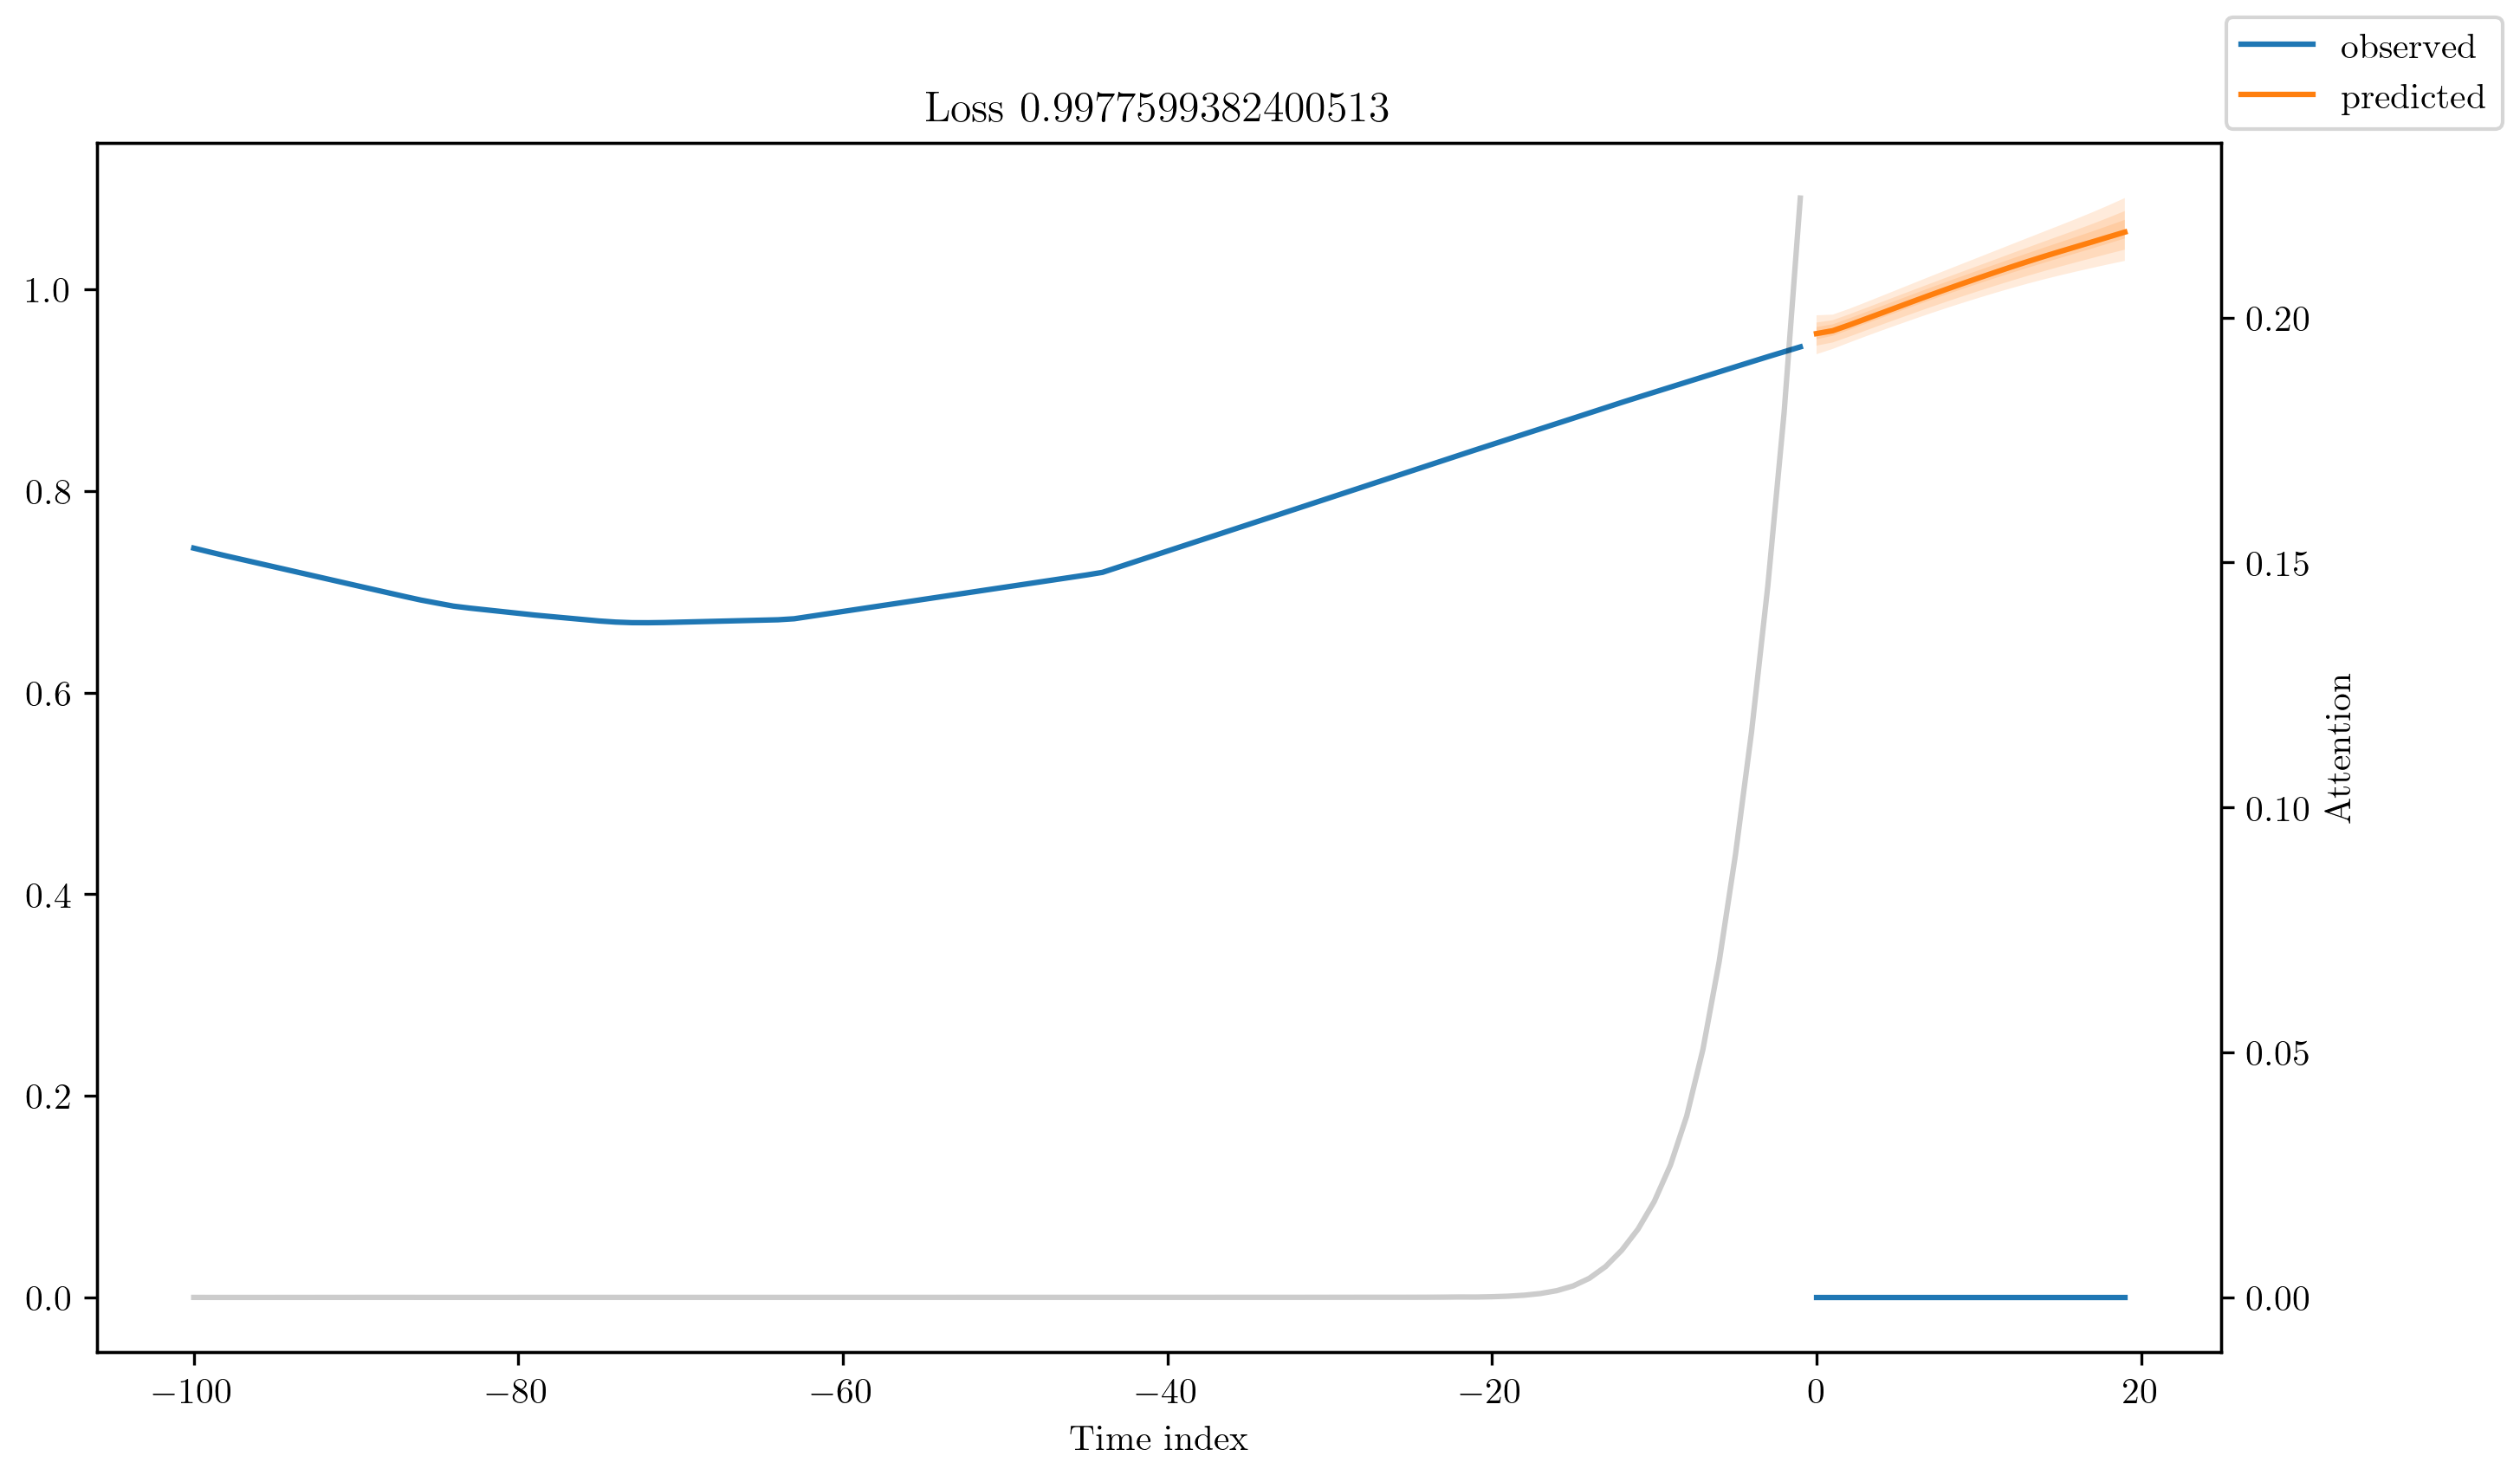

In [53]:
fig = best_model2.plot_prediction(x_new, raw_tests, idx=0, add_loss_to_title=True)
fig.set_dpi(300)
fig.set_figwidth(10)
fig.set_figheight(6)
fig.savefig("tft_predict_new.png")
fig.show()

In [54]:
def pred_step(n):
    # Last Observed Data + Dummy Decoded Data
    x_test = torch.concat([x_val['encoder_target'][:], torch.repeat_interleave(torch.tensor(0.0), 20)])
    
    # Container
    y_preds = []
    
    for i in range(n):
        ts_test = pd.DataFrame(
            dict(
                y=x_test,
                group=np.repeat(0, 120),
                time_idx=np.arange(880+20*i,1000+20*i)
            )
        )
        ts_test = ts_test.astype(dict(group=str))

        # DataFrame to TimeSeriesDataSet
        ds_test = TimeSeriesDataSet(
            ts_test,
            target="y",
            time_idx="time_idx",
            group_ids=["group"],
            time_varying_known_reals=["time_idx"],
            time_varying_unknown_reals=["y"],
            max_encoder_length=max_encoder_length,
            max_prediction_length=max_prediction_length
        )
        
        # Prediction
        y_new = best_model2.predict(ds_test)[0]
        y_preds.extend(y_new.detach().cpu().tolist())
        
        # Update Data
        x_test = torch.concat([x_test[20:100], y_new, torch.repeat_interleave(torch.tensor(0.0), 20)])
    
    return torch.tensor(y_preds)

In [55]:
test_data = gen_noisy_data(1500, range_x=[-2,4], sc=sc)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

In [56]:
y_preds = pred_step(26)
x_preds = x[980:]

In [57]:
test_data = gen_noisy_data(1500, range_x=[-2,4], sc=sc)
x = test_data.x
y = test_data.y
y_true = test_data.y_true
y_hat = best_model(x).detach().cpu().numpy()

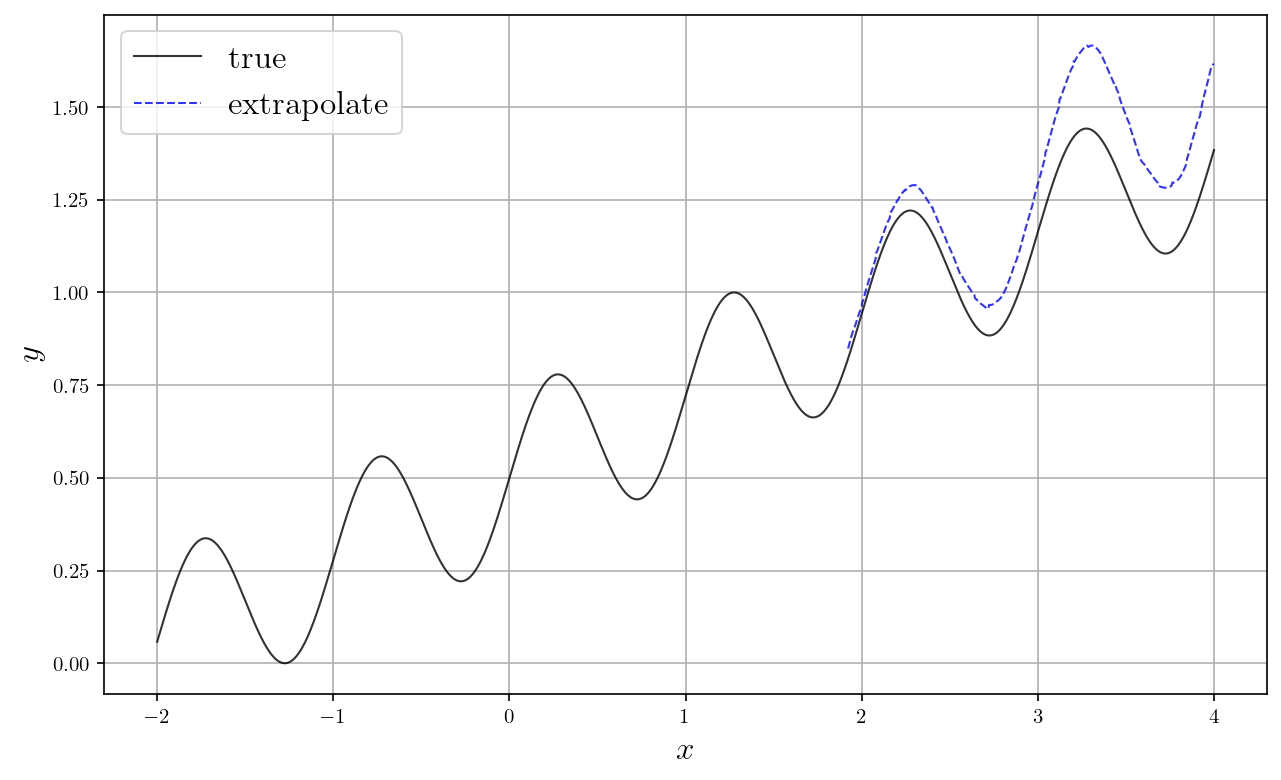

In [58]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x_preds, y_preds, 'b--', linewidth=1, label='extrapolate', alpha=0.8)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)
# plt.xlim([1.5, 2.0])
# plt.ylim([0.6, 1.0])
plt.show()

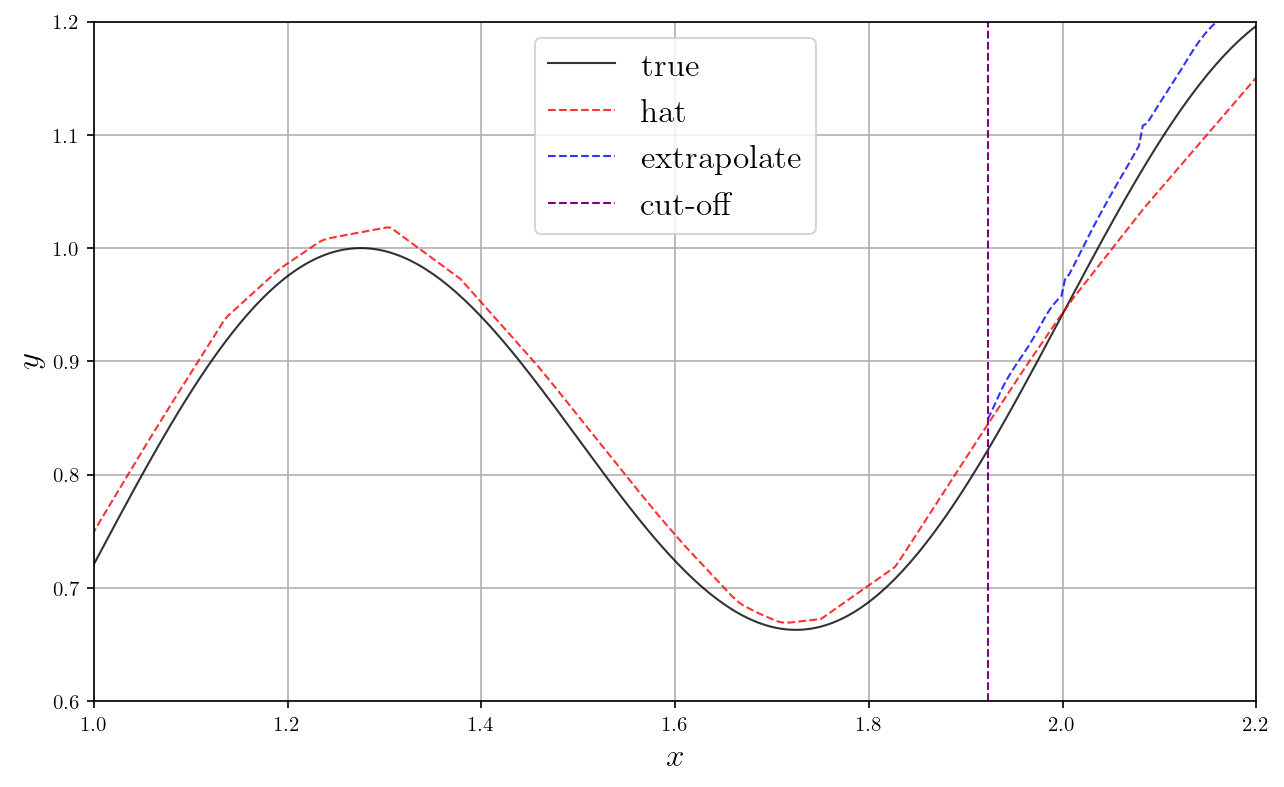

In [59]:
plt.figure(figsize=(10, 6), dpi=150)
plt.plot(x, y_true, 'k-', linewidth=1, label='true', alpha=0.8)
plt.plot(x, y_hat, 'r--', linewidth=1, label='hat', alpha=0.8)
# plt.plot(x[:980], best_model2.predict(ds_train), 'g--', linewidth=1, label='pred', alpha=0.8)
plt.plot(x_preds, y_preds, 'b--', linewidth=1, label='extrapolate', alpha=0.8)
plt.axvline(x_preds[0], color='purple', linewidth=1, linestyle='dashed', label='cut-off')
plt.legend(fontsize=16)
plt.grid()
plt.xlabel(r"$x$", fontsize=16)
plt.ylabel(r"$y$", fontsize=16)

plt.xlim([1.0, 2.2])
plt.ylim([0.6, 1.2])

# plt.savefig("rnn_extrapolate.png")
plt.show()